In [3]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px


base_path = os.getcwd()
proj_path = os.path.join(base_path, "Project_2") #/ECE219/Project_2
print(f"base_path: {base_path}")
print(f"proj_path: {proj_path}")

sys.path.append(proj_path)
from pokedex_helper import *

csv_path = os.path.join(proj_path, "Pokemon.csv")
image_dir = os.path.join(proj_path, "images")

base_path: /Users/richardlee/Desktop/UCLA/Classes/2025_Winter/ECE219/ECE219
proj_path: /Users/richardlee/Desktop/UCLA/Classes/2025_Winter/ECE219/ECE219/Project_2


In [ ]:
def get_top_pokemon_from_queries(pokedex:pd.DataFrame, queries:list, model, preprocess, device, top_n:int =5):
    query_embeddings = clip_inference_text(model, preprocess, queries, device)
    image_embeddings = clip_inference_image(model, preprocess, pokedex["image_path"], device)

    similarity = compute_similarity_image_to_text(image_embeddings, query_embeddings)
    top_n_pokemon_ids = {}
    for i, query in enumerate(queries):
        top_indices = np.argsort(similarity[:,i])[-top_n:][::-1]
        top_ids = pokedex.iloc[top_indices]["ID"].values
        top_n_pokemon_ids[query] = top_ids
        top_probs = [similarity[idx, i] for idx in top_indices]
        print(top_probs)
    return top_n_pokemon_ids

def plot_top_pokemon(pokedex, top_pokemon_ids):
    """Plots the top 5 Pokémon for each query."""
    for query, pokemon_ids in top_pokemon_ids.items():
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        fig.suptitle(query, fontsize=14)

        for i, pokemon_id in enumerate(pokemon_ids):
            row = pokedex[pokedex["ID"]==pokemon_id]
            image = Image.open(row["image_path"].values[0])
            axes[i].imshow(image)
            axes[i].axis("off")
            axes[i].set_title(f"{row['Name'].values[0]}\n({row['Type1'].values[0]}, {row['Type2'].values[0]})")
        plt.show()

def umap_projection(pokedex, type_filter, model, preprocess, device, n_neighbors=15, min_dist=0.1, metric='cosine'):
    filtered_pokedex = pokedex[(pokedex["Type1"].isin(type_filter)) | (pokedex["Type1"].isin(type_filter))]
    
    image_embeddings = clip_inference_image(model, preprocess, filtered_pokedex["image_path"], device)
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))

    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    
    distance_matrix = 1 - distance_matrix  # Convert to a distance metric

    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    tsne_df = pd.DataFrame(visualization_data, columns=["x", "y"])
    tsne_df["Pokemon"] = filtered_pokedex["Name"].values
    tsne_df["Type1"] = filtered_pokedex["Type1"].values
    tsne_df["Type2"] = filtered_pokedex["Type2"].values

    # Create a new column to display both types
    tsne_df["Types"] = tsne_df.apply(
        lambda row: f"{row['Type1']} / {row['Type2']}" if pd.notna(row['Type2']) else row['Type1'], axis=1
    )

    # Plot t-SNE clusters
    fig = px.scatter(
        tsne_df, x="x", y="y", color="Type1", hover_name="Pokemon", hover_data=["Types"],
        title=f"t-SNE Clustering of {', '.join(type_filter)} Pokemon"
    )
    fig.show()

100%|██████████| 754/754 [00:32<00:00, 22.95it/s]


[0.0657, 0.0528, 0.05115, 0.04517, 0.04047]
[0.1133, 0.0828, 0.07544, 0.0606, 0.04504]
[0.04648, 0.04648, 0.02954, 0.0291, 0.02864]
[0.04694, 0.04617, 0.03952, 0.03772, 0.03598]
[0.1433, 0.0698, 0.04507, 0.04303, 0.0417]


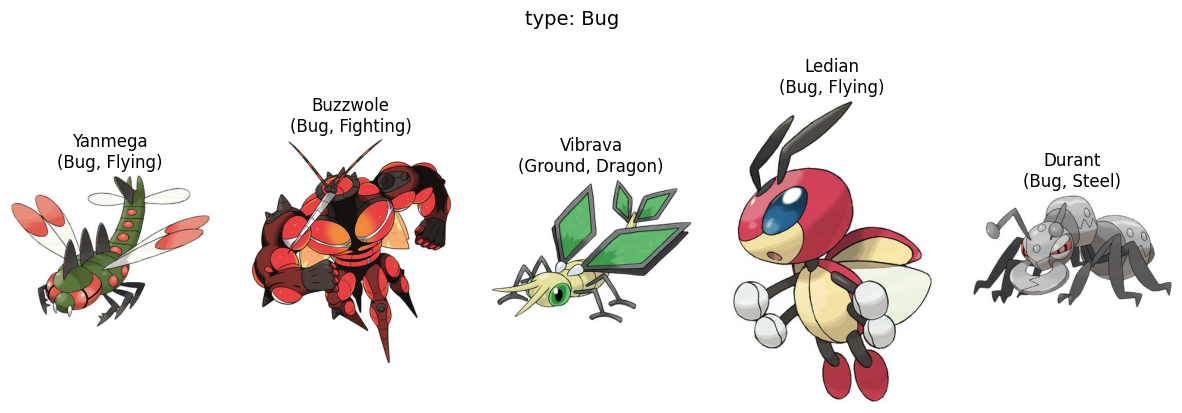

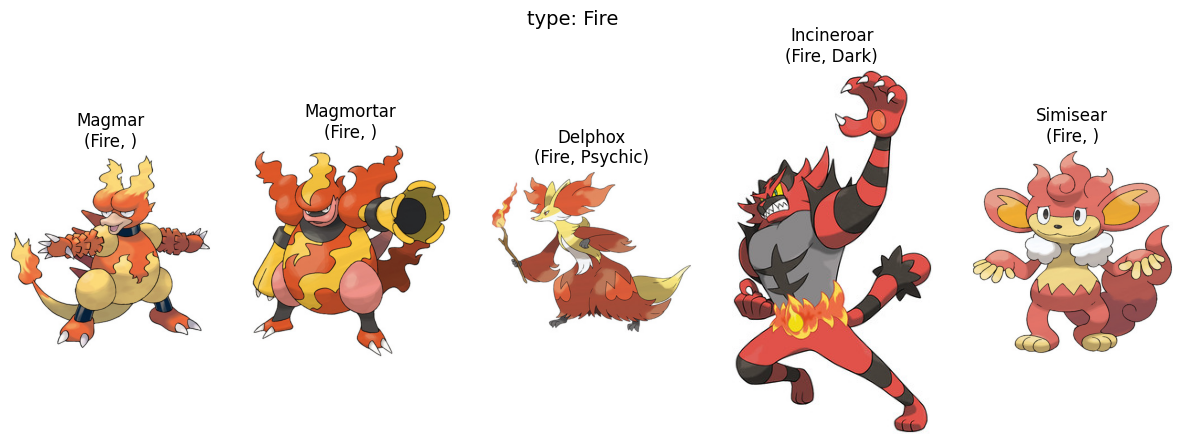

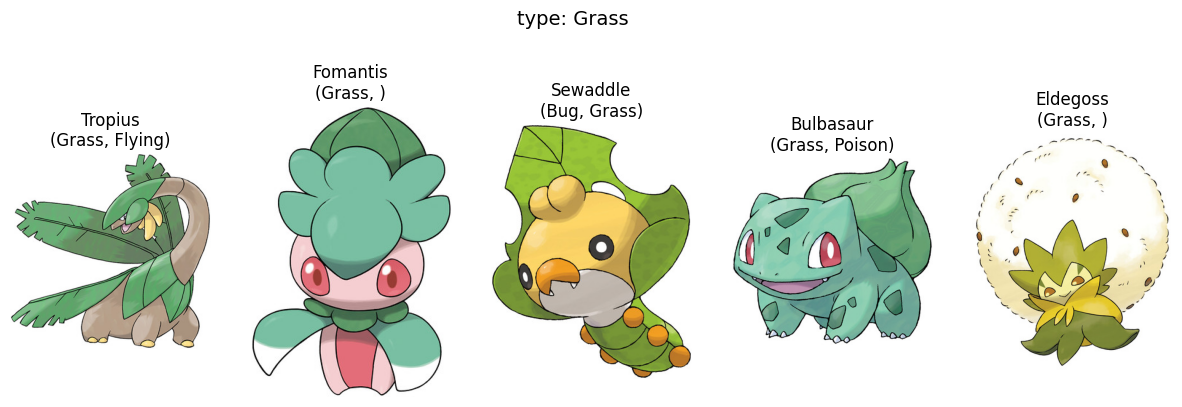

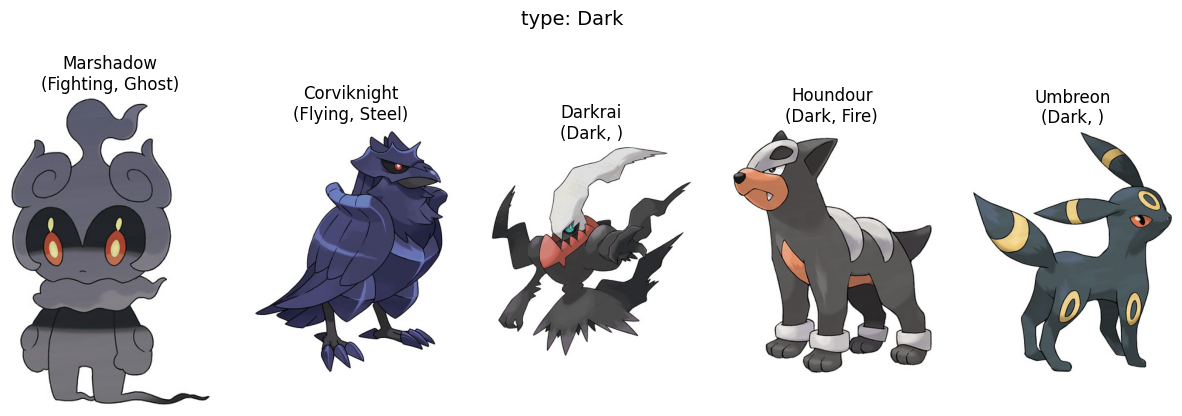

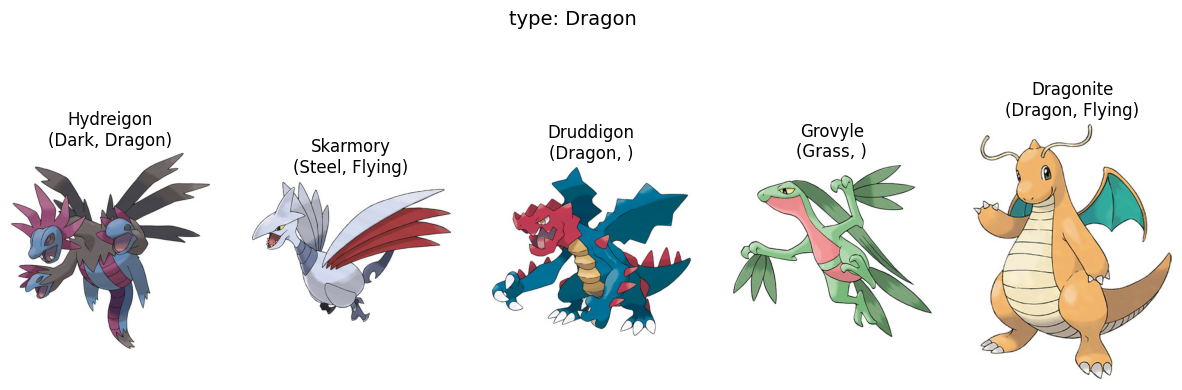

In [3]:
# Load Pokedex
pokedex = construct_pokedex(csv_path, image_dir)

# Load CLIP
model, preprocess, device = load_clip_model()

# Create Queries
queries = [
    "Bug type pokemon", "fire type pokemon", "grass type pokemon", "dark type pokemon", "dragon type pokemon"
]

queries2 = [
    "type: Bug", "type: Fire", "type: Grass",
    "type: Dark", "type: Dragon"
]

top_5_pokemon_ids = get_top_pokemon_from_queries(pokedex, queries2, model, preprocess, device, top_n=5)
plot_top_pokemon(pokedex, top_5_pokemon_ids)

,ID,Name,Form,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,image_path
389,489,Phione,,Water,,480,80,80,80,80,80,80,4,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...
136,188,Skiploom,,Grass,Flying,340,55,45,50,45,65,80,2,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...
415,517,Munna,,Psychic,,292,76,25,45,67,55,24,5,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...
181,242,Blissey,,Normal,,540,255,10,10,75,135,55,2,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...
574,695,Heliolisk,,Electric,Normal,481,62,55,52,109,94,109,6,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...
116,167,Spinarak,,Bug,Poison,250,40,60,40,40,40,30,2,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...
750,894,Regieleki,,Electric,,580,80,100,50,100,50,200,8,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...
593,718,Zygarde,Complete Forme,Dragon,Ground,708,216,100,121,91,95,85,7,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...
283,363,Spheal,,Ice,Water,290,70,40,50,55,50,25,3,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...
448,553,Krookodile,,Ground,Dark,519,95,117,80,65,70,92,5,/Users/richardlee/Desktop/UCLA/Classes/2025_Wi...


100%|██████████| 10/10 [00:00<00:00, 23.35it/s]


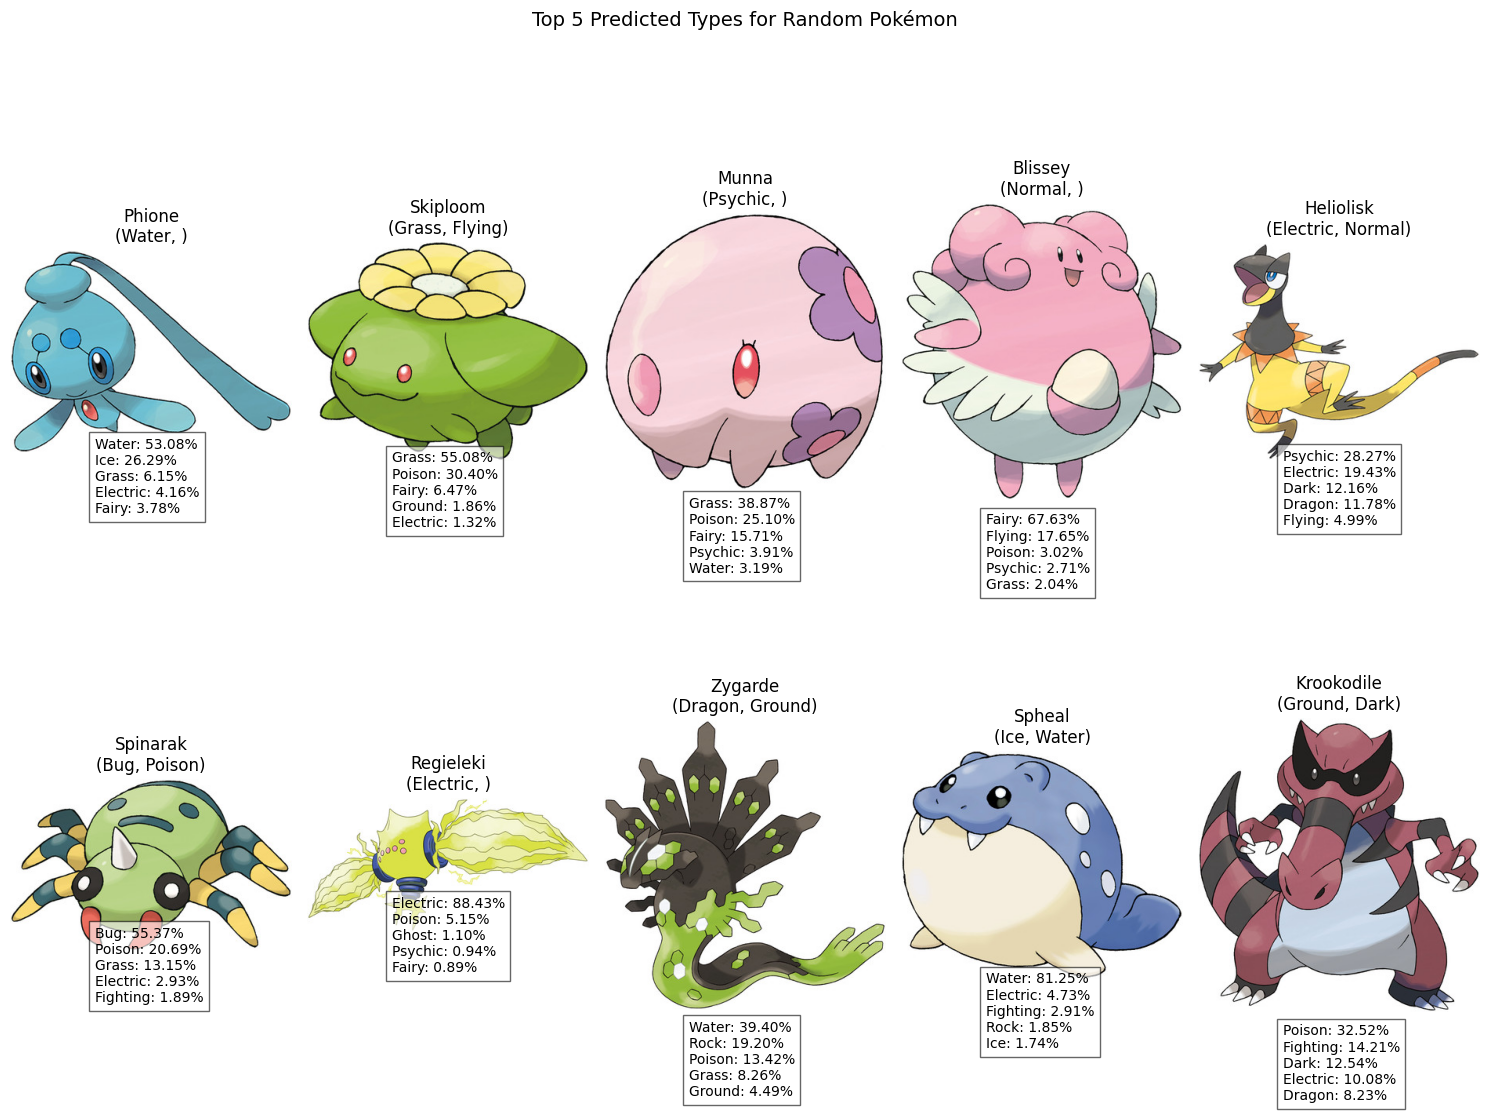

In [50]:
# Define Pokémon types for CLIP text queries
POKEMON_TYPES = ["Bug", "Dark", "Dragon", "Electric", "Fairy", "Fighting", "Fire", "Flying", 
                 "Ghost", "Grass", "Ground", "Ice", "Normal", "Poison", "Psychic", "Rock", "Steel", "Water"]

# Select 10 random Pokémon from the dataset
random_pokedex_sample = pokedex.sample(n=10, 
                                       #random_state=42
                                       )
display(random_pokedex_sample)

# Create text queries for each Pokémon type
type_queries = [f"type: {pokemon_type}" for pokemon_type in POKEMON_TYPES]

# Get CLIP embeddings for the type queries
model, preprocess, device = load_clip_model()
text_embeddings = clip_inference_text(model, preprocess, type_queries, device)

# Get image embeddings for the 10 selected Pokémon
image_embeddings = clip_inference_image(model, preprocess, random_pokedex_sample["image_path"], device)

# Compute similarity scores
similarity = compute_similarity_text_to_image(image_embeddings, text_embeddings)

# Plot each Pokémon with its predicted type probabilities
fig, axes = plt.subplots(2, 5, figsize=(15, 12))  # Adjusted size for clarity
fig.suptitle("Top 5 Predicted Types for Random Pokémon", fontsize=14)

for i, (index, row) in enumerate(random_pokedex_sample.iterrows()):
    row_idx, col_idx = divmod(i, 5)  # Convert 1D index to 2D (row, col)

    # Get top 5 predicted types and probabilities
    top_indices = np.argsort(similarity[i,:])[-5:][::-1]
    top_types = [POKEMON_TYPES[idx] for idx in top_indices]
    top_probs = [similarity[i, idx] for idx in top_indices]

    # Load and display the Pokémon image
    image = Image.open(row["image_path"])
    axes[row_idx, col_idx].imshow(image)
    axes[row_idx, col_idx].axis("off")
    
    # Add Pokémon name and actual types
    title_text = f"{row['Name']}\n({row['Type1']}, {row['Type2']})"
    axes[row_idx, col_idx].set_title(title_text, fontsize=12)
    
    # Display the predicted types with probabilities
    img_width, img_height = image.size
    prob_text = "\n".join([f"{ptype}: {prob:.2%}" for ptype, prob in zip(top_types, top_probs)])
    axes[row_idx, col_idx].text(0.3, -0.3, prob_text, transform=axes[row_idx, col_idx].transAxes, 
        fontsize=10, bbox={"facecolor": "white", "alpha": 0.6}
    )
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Give space for the title
plt.show()

In [ ]:
umap_projection(pokedex, ["Bug", "Fire", "Grass"], model, preprocess, device)

100%|██████████| 192/192 [00:08<00:00, 23.74it/s]
